In [ ]:
! ls

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import Images

## 1.1 Convert tif to jpeg

In [ ]:
#Create a folder with all jpeg images
import os
import shutil

TILE_RANGE = 1766

IMAGE_INPUT_DIRECTORY = '/Users/user/Library/Mobile Documents/com~apple~CloudDocs/[02]-work/[02]-2023-le-wagon/[04]-final-project/train_data/train_lidar'
IMAGE_OUTPUT_DIRECTORY = '/Users/user/Desktop/MAIA-yolo/0_second_run/train_lidar_tif'

# Copying the images
for i in range(TILE_RANGE):
    input_image_path = os.path.join(IMAGE_INPUT_DIRECTORY, f'tile_{i}.tif')
    output_image_path = os.path.join(IMAGE_OUTPUT_DIRECTORY, f'tile_{i}.tif')
    shutil.copy2(input_image_path,output_image_path)


In [ ]:
#Copy a given number of tiles to YOLO training folder

tiles_number = 500
val_percentage = 0.20

IMAGE_INPUT_DIRECTORY = '/Users/user/Desktop/MAIA-yolo/0_second_run/train_lidar_jpeg/'
IMAGE_OUTPUT_DIRECTORY_TRAIN = '/Users/user/Desktop/MAIA-yolo/0_second_run/datasets/images-v1/images/train/'
IMAGE_OUTPUT_DIRECTORY_VAL = '/Users/user/Desktop/MAIA-yolo/0_second_run/datasets/images-v1/images/val/'

#Copying the images
for i in range(int(tiles_number*(1-val_percentage))):
    input_image_path = os.path.join(IMAGE_INPUT_DIRECTORY, f'tile_{i}.jpeg')
    output_image_path = os.path.join(IMAGE_OUTPUT_DIRECTORY_TRAIN, f'tile_{i-1}.jpeg')
    shutil.copy2(input_image_path,output_image_path)

for i in range(int(tiles_number*(1-val_percentage)),int(tiles_number*(1-val_percentage) + tiles_number*val_percentage)):
    input_image_path = os.path.join(IMAGE_INPUT_DIRECTORY, f'tile_{i}.jpeg')
    output_image_path = os.path.join(IMAGE_OUTPUT_DIRECTORY_VAL, f'tile_{i-1}.jpeg')
    shutil.copy2(input_image_path,output_image_path)


## 1.2 Create masks

In [ ]:
#Copy masks to train_masks_selection folder
#copy train masks

train_number = 500

IMAGE_INPUT_DIRECTORY = '/Users/user/Desktop/MAIA-yolo/0_second_run/train_masks/'
IMAGE_OUTPUT_DIRECTORY_AGUADA = '/Users/user/Desktop/MAIA-yolo/0_second_run/train_masks_selection/aguada'
IMAGE_OUTPUT_DIRECTORY_PLATFORM = '/Users/user/Desktop/MAIA-yolo/0_second_run/train_masks_selection/platform'
IMAGE_OUTPUT_DIRECTORY_BUILDING = '/Users/user/Desktop/MAIA-yolo/0_second_run/train_masks_selection/building'

for i in range(train_number):
    input_image_path = os.path.join(IMAGE_INPUT_DIRECTORY, f'tile_{i}_mask_aguada.tif')
    #output_image_path = os.path.join(IMAGE_OUTPUT_DIRECTORY_AGUADA, f'tile_{i}_mask_aguada.tif')
    output_image_path = os.path.join(IMAGE_OUTPUT_DIRECTORY_AGUADA, f'tile_{i}.tif')
    shutil.copy2(input_image_path,output_image_path)

for i in range(train_number):
    input_image_path = os.path.join(IMAGE_INPUT_DIRECTORY, f'tile_{i}_mask_building.tif')
    #output_image_path = os.path.join(IMAGE_OUTPUT_DIRECTORY_BUILDING, f'tile_{i}_mask_building.tif')
    output_image_path = os.path.join(IMAGE_OUTPUT_DIRECTORY_BUILDING, f'tile_{i}.tif')
    shutil.copy2(input_image_path,output_image_path)

for i in range(train_number):
    input_image_path = os.path.join(IMAGE_INPUT_DIRECTORY, f'tile_{i}_mask_platform.tif')
    #output_image_path = os.path.join(IMAGE_OUTPUT_DIRECTORY_PLATFORM, f'tile_{i}_mask_platform.tif')
    output_image_path = os.path.join(IMAGE_OUTPUT_DIRECTORY_PLATFORM, f'tile_{i}.tif')
    shutil.copy2(input_image_path,output_image_path)

In [ ]:
##########################################################
# To run the mask to COCO conversion: Use main_maia.py
# json file located in output-json folder
##########################################################

In [ ]:
# To convert COCO to YOLO : https://github.com/ultralytics/JSON2YOLO

In [ ]:
import contextlib
import json

import numpy as np

import cv2
import pandas as pd
from PIL import Image
from collections import defaultdict
from pathlib import Path
from PIL import ExifTags
from tqdm import tqdm

In [ ]:
# Parameters
img_formats = ['bmp', 'jpg', 'jpeg', 'png', 'tif', 'tiff', 'dng']  # acceptable image suffixes
vid_formats = ['mov', 'avi', 'mp4', 'mpg', 'mpeg', 'm4v', 'wmv', 'mkv']  # acceptable video suffixes

# Get orientation exif tag
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break


def exif_size(img):
    # Returns exif-corrected PIL size
    s = img.size  # (width, height)
    try:
        rotation = dict(img._getexif().items())[orientation]
        if rotation in [6, 8]:  # rotation 270
            s = (s[1], s[0])
    except:
        pass

    return s


def split_rows_simple(file='../data/sm4/out.txt'):  # from utils import *; split_rows_simple()
    # splits one textfile into 3 smaller ones based upon train, test, val ratios
    with open(file) as f:
        lines = f.readlines()

    s = Path(file).suffix
    lines = sorted(list(filter(lambda x: len(x) > 0, lines)))
    i, j, k = split_indices(lines, train=0.9, test=0.1, validate=0.0)
    for k, v in {'train': i, 'test': j, 'val': k}.items():  # key, value pairs
        if v.any():
            new_file = file.replace(s, f'_{k}{s}')
            with open(new_file, 'w') as f:
                f.writelines([lines[i] for i in v])


def split_files(out_path, file_name, prefix_path=''):  # split training data
    file_name = list(filter(lambda x: len(x) > 0, file_name))
    file_name = sorted(file_name)
    i, j, k = split_indices(file_name, train=0.9, test=0.1, validate=0.0)
    datasets = {'train': i, 'test': j, 'val': k}
    for key, item in datasets.items():
        if item.any():
            with open(f'{out_path}_{key}.txt', 'a') as file:
                for i in item:
                    file.write('%s%s\n' % (prefix_path, file_name[i]))


def split_indices(x, train=0.9, test=0.1, validate=0.0, shuffle=True):  # split training data
    n = len(x)
    v = np.arange(n)
    if shuffle:
        np.random.shuffle(v)

    i = round(n * train)  # train
    j = round(n * test) + i  # test
    k = round(n * validate) + j  # validate
    return v[:i], v[i:j], v[j:k]  # return indices


def make_dirs(dir='../output-yolo/'):
    # Create folders
    dir = Path(dir)
    if dir.exists():
        shutil.rmtree(dir)  # delete dir
    for p in dir, dir / 'labels': #, dir / 'images':
        p.mkdir(parents=True, exist_ok=True)  # make dir
    return dir


def write_data_data(fname='data.data', nc=80):
    # write darknet *.data file
    lines = ['classes = %g\n' % nc,
             'train =../out/data_train.txt\n',
             'valid =../out/data_test.txt\n',
             'names =../out/data.names\n',
             'backup = backup/\n',
             'eval = coco\n']

    with open(fname, 'a') as f:
        f.writelines(lines)


def image_folder2file(folder='images/'):  # from utils import *; image_folder2file()
    # write a txt file listing all imaged in folder
    s = glob.glob(f'{folder}*.*')
    with open(f'{folder[:-1]}.txt', 'w') as file:
        for l in s:
            file.write(l + '\n')  # write image list


def add_coco_background(path='../data/sm4/', n=1000):  # from utils import *; add_coco_background()
    # add coco background to sm4 in outb.txt
    p = f'{path}background'
    if os.path.exists(p):
        shutil.rmtree(p)  # delete output folder
    os.makedirs(p)  # make new output folder

    # copy images
    for image in glob.glob('../coco/images/train2014/*.*')[:n]:
        os.system(f'cp {image} {p}')

    # add to outb.txt and make train, test.txt files
    f = f'{path}out.txt'
    fb = f'{path}outb.txt'
    os.system(f'cp {f} {fb}')
    with open(fb, 'a') as file:
        file.writelines(i + '\n' for i in glob.glob(f'{p}/*.*'))
    split_rows_simple(file=fb)


def create_single_class_dataset(path='../data/sm3'):  # from utils import *; create_single_class_dataset('../data/sm3/')
    # creates a single-class version of an existing dataset
    os.system(f'mkdir {path}_1cls')


def flatten_recursive_folders(path='../../Downloads/data/sm4/'):  # from utils import *; flatten_recursive_folders()
    # flattens nested folders in path/images and path/JSON into single folders
    idir, jdir = f'{path}images/', f'{path}json/'
    nidir, njdir = Path(f'{path}images_flat/'), Path(f'{path}json_flat/')
    n = 0

    # Create output folders
    for p in [nidir, njdir]:
        if os.path.exists(p):
            shutil.rmtree(p)  # delete output folder
        os.makedirs(p)  # make new output folder

    for parent, dirs, files in os.walk(idir):
        for f in tqdm(files, desc=parent):
            f = Path(f)
            stem, suffix = f.stem, f.suffix
            if suffix.lower()[1:] in img_formats:
                n += 1
                stem_new = '%g_' % n + stem
                image_new = nidir / (stem_new + suffix)  # converts all formats to *.jpg
                json_new = njdir / f'{stem_new}.json'

                image = parent / f
                json = Path(parent.replace('images', 'json')) / str(f).replace(suffix, '.json')

                os.system("cp '%s' '%s'" % (json, json_new))
                os.system("cp '%s' '%s'" % (image, image_new))
                # cv2.imwrite(str(image_new), cv2.imread(str(image)))

    print('Flattening complete: %g jsons and images' % n)


def coco91_to_coco80_class():  # converts 80-index (val2014) to 91-index (paper)
    # https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
    x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, None, 24, 25, None,
         None, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, None, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52, 53, 54, 55, 56, 57, 58, 59, None, 60, None, None, 61, None, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
         None, 73, 74, 75, 76, 77, 78, 79, None]
    return x

In [ ]:
def convert_coco_json(json_dir='output-json/', use_segments=True, cls91to80=False):
    save_dir = make_dirs()  # output directory
    coco80 = coco91_to_coco80_class()

    # Import json
    for json_file in sorted(Path(json_dir).resolve().glob('*.json')):
        fn = Path(save_dir) / 'labels' / json_file.stem.replace('instances_', '')  # folder name
        fn.mkdir()
        with open(json_file) as f:
            data = json.load(f)

        # Create image dict
        images = {'%g' % x['id']: x for x in data['images']}
        # Create image-annotations dict
        imgToAnns = defaultdict(list)
        for ann in data['annotations']:
            imgToAnns[ann['image_id']].append(ann)

        # Write labels file
        for img_id, anns in tqdm(imgToAnns.items(), desc=f'Annotations {json_file}'):
            img = images['%g' % img_id]
            h, w, f = img['height'], img['width'], img['file_name']

            bboxes = []
            segments = []
            for ann in anns:
                if ann['iscrowd']:
                    continue
                # The COCO box format is [top left x, top left y, width, height]
                box = np.array(ann['bbox'], dtype=np.float64)
                box[:2] += box[2:] / 2  # xy top-left corner to center
                box[[0, 2]] /= w  # normalize x
                box[[1, 3]] /= h  # normalize y
                if box[2] <= 0 or box[3] <= 0:  # if w <= 0 and h <= 0
                    continue

                cls = coco80[ann['category_id'] - 1] if cls91to80 else ann['category_id'] - 1  # class
                box = [cls] + box.tolist()
                if box not in bboxes:
                    bboxes.append(box)
                # Segments
                if use_segments:
                    if len(ann['segmentation']) > 1:
                        s = merge_multi_segment(ann['segmentation'])
                        s = (np.concatenate(s, axis=0) / np.array([w, h])).reshape(-1).tolist()
                    else:
                        s = [j for i in ann['segmentation'] for j in i]  # all segments concatenated
                        s = (np.array(s).reshape(-1, 2) / np.array([w, h])).reshape(-1).tolist()
                    s = [cls] + s
                    if s not in segments:
                        segments.append(s)

            # Write
            with open((fn / f).with_suffix('.txt'), 'a') as file:
                for i in range(len(bboxes)):
                    line = *(segments[i] if use_segments else bboxes[i]),  # cls, box or segments
                    file.write(('%g ' * len(line)).rstrip() % line + '\n')

In [ ]:
# Output is under: /output-yolo
# Chould then be checked in Roboflow - but need to convert the images to JPEG or PNG
convert_coco_json(json_dir='../output-json/', use_segments=True, cls91to80=False)

Annotations /Users/user/Desktop/MAIA-yolo/0_second_run/output-json/train.json: 100%|█| 342/342 [00:00<00:00, 1205.43it/s


In [ ]:
#Transfer masks in YOLO datasets for training

In [ ]:
!pwd

/Users/user/Desktop/MAIA-yolo/0_second_run/yolov8


# 2. Convert from tif to jpeg

In [ ]:
from PIL import Image


for i in range(100):
    im = Image.open(f'imgs/tile_{i}.tif')
    im.save(f'new_dir/images/tile_{i}.jpeg')

FileNotFoundError: [Errno 2] No such file or directory: 'imgs/tile_0.tif'

In [ ]:
#Copy and transform images for training
IMAGE_INPUT_DIRECTORY = '/Users/user/Library/Mobile Documents/com~apple~CloudDocs/[02]-work/[02]-2023-le-wagon/[04]-final-project/train_data/train_lidar/'
IMAGE_OUTPUT_DIRECTORY = './imgs'

TILE_RANGE=100

#! ls './imgs'
#! ls '../../Maya_competition_lidar_data/images/train'

# Copying the images
for i in range(TILE_RANGE):
    input_image_path = os.path.join(IMAGE_INPUT_DIRECTORY, f'tile_{i}.tif')
    output_image_path = os.path.join(IMAGE_OUTPUT_DIRECTORY, f'tile_{i}.tif')
    shutil.copy2(input_image_path,output_image_path)

# 3. YOLO v8

In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.1/629.1 kB 22.5 MB/s eta 0:00:00


In [2]:
! pip install pycocotools


In [ ]:
!pwd

/content


In [5]:
from ultralytics import YOLO

# Create a new YOLO model from scratch
#model = YOLO('yolov8n.yaml')

# Load a pretrained YOLO model (recommended for training)
model = YOLO('yolov8l-seg.pt')

# Train the model using the 'coco128.yaml' dataset for 3 epochs
results = model.train(data='/content/drive/MyDrive/yolo-test-20230713/yolov8/custom.yaml', epochs=100)

# Evaluate the model's performance on the validation set
results = model.val()

Ultralytics YOLOv8.0.134 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=segment, mode=train, model=yolov8l-seg.pt, data=/content/drive/MyDrive/yolo-test-20230713/yolov8/custom.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=F

In [ ]:
# Perform object detection on an image using the model
results = model('/Users/user/Desktop/MAIA-yolo/0_first_run/datasets/images-v0/tile_1780_lidar.jpeg')

Ultralytics YOLOv8.0.0 🚀 Python-3.10.6 torch-2.0.1 CPU
Fusing layers... 
YOLOv8n-seg summary: 195 layers, 3258649 parameters, 32681 gradients, 12.0 GFLOPs
image 1/1 /Users/user/Desktop/MAIA-yolo/0_first_run/datasets/images-v0/tile_1780_lidar.jpeg: 640x640 104.2ms
Speed: 1.5ms pre-process, 104.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


# Contours with OpenCV

We will be making a copy of our original image using img.copy() to draw contours on that copy image so that our original image is preserved.
To draw contours we use cv2.drawContours() method. The first argument represents the image source, the second argument represents the contours that should be passed as a Python list, the third argument is used as an index of Contours, and other arguments are used for color thickness.


In [ ]:
def contours_detection(tile):
    path = '/Users/user/Library/Mobile Documents/com~apple~CloudDocs/[02]-work/[02]-2023-le-wagon/[04]-final-project/train_data/\
train_masks/' + f'{tile}' + '.tif'
    #read image
    img = cv2.imread(path)
    #convert from BGR to RGB
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #convert to greyscale for thersholding
    gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    gray=255-gray
    #Thresholding the image to detect contours
    ret, thresh = cv2.threshold(gray, 125, 255, 0)
    #(Image.fromarray(thresh)).show()
    #Let’s detect contours…
    #Syntax: cv2.findContours(src, contour_retrieval, contours_approximation)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    print(len(contours))
    copy_img = img.copy()
    cv2.drawContours(copy_img,contours,-1,(255,0,0),2)
    titles = ['original','contours']
    imgs = [img, copy_img]
    for i in range (2):
        plt.subplot(1,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title(titles[i])
        plt.imshow(imgs[i])

    return plt.show()

In [ ]:
contours_detection('tile_4_mask_building')

0


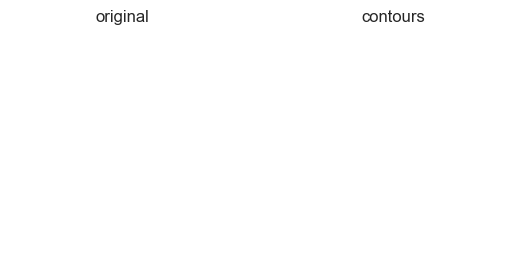

In [ ]:
contours_detection('tile_0_mask_building')

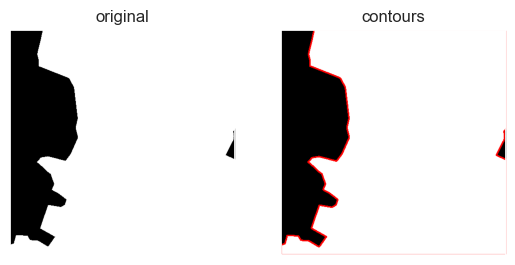

In [ ]:
contours_detection('tile_1257_mask_platform')

In [ ]:
path = '/Users/user/Library/Mobile Documents/com~apple~CloudDocs/[02]-work/[02]-2023-le-wagon/[04]-final-project/train_data/\
train_masks/tile_1257_mask_platform.tif'
img = cv2.imread(path)
img

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]